# Introduction to Logistic Regression

You have seen how to build a linear regression model. A linear regression model is useful if predicting a *numeric* outcome. What if you want to predict a *categorical* outcome?

In this notebook, you'll learn how you can use a **logistic regression** model for just such a situation.

In this notebook, you will be looking at data related to Duchenne Muscular Dystrophy (DMD). DMD is a genetically transmitted disease, passed from a mother to her children. Affected female offspring usually suffer no apparent symptoms, male offspring with the disease die at young age. Although female carriers have no physical symptoms they tend to exhibit elevated levels of certain serum enzymes or proteins. 

The dystrophy dataset contains 209 observations of 75 female DMD carriers and 134 female DMD non-carriers. It includes 6 variables describing the age of the female and the serum parameters serum marker creatine kinase (CK), serum marker hemopexin (H), serum marker pyruvate kinase (PK) and serum marker lactate dehydroginase (LD). The serum markers CK and H may be measured rather inexpensively from frozen serum, while PK and LD require fresh serum.

In [2]:
import pandas as pd
import numpy as np

In [3]:
dystrophy = pd.read_csv('../data/dystrophy.csv')

In [4]:
dystrophy.head()

,OBS,HospID,AGE,M,Y,CK,H,PK,LD,Class
0,1,1007,22,6,79,52.0,83.5,10.9,176.0,normal
1,1,786,32,8,78,20.0,77.0,11.0,200.0,normal
2,1,778,36,7,78,28.0,86.5,13.2,171.0,normal
3,1,1306,22,11,79,30.0,104.0,22.6,230.0,normal
4,1,895,23,1,78,40.0,83.0,15.2,205.0,normal


Start by doing some prelimilary exploratory analysis.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

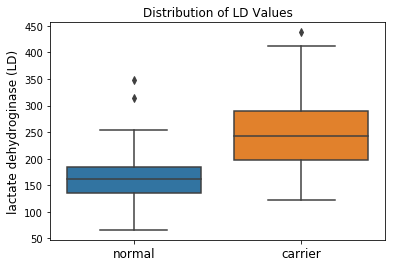

In [6]:
sns.boxplot(data = dystrophy, x = 'Class', y = 'LD')
plt.ylabel('lactate dehydroginase (LD)', fontsize = 12)
plt.xlabel('')
plt.xticks(fontsize = 12)
plt.title('Distribution of LD Values', fontsize = 12);

You can see, in the dataset, that carriers tend to have higher LD values. However, there is some overlap between carriers and non-carriers in the middle values. There is not a single cutoff you can use to classify a person as a carrier or non-carrier.

Now you're going to look at the above plot in a different way. To accomplish this, you're going to encode the normal/carrier classification numerically. Mark carriers with a 1 and non-carriers with a 0.

In [7]:
dystrophy['carrier'] = (dystrophy.Class == 'carrier').astype('int')

Now we can view our data as a scatterplot:

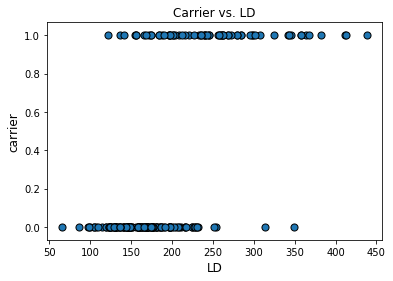

In [8]:
dystrophy.plot(x = 'LD', y = 'carrier', kind = 'scatter', edgecolor = 'black', s = 50)
plt.title('Carrier vs. LD')
plt.ylabel('carrier', fontsize = 12)
plt.xlabel('LD', fontsize = 12);

Since there is overlap between carriers and non-carriers, you would probably be best off not making a simple prediction of carrier/non-carrier, but instead predicting the likelihood or probability that a female is a carrier.

From what is seen in the plots, females with higher LD values look more likely to be carriers that those with lower values.

Between 175 and 225, it is not clear if a person is a carrier or not, so you might be best off assigning a probability close to 0.5 for people in that range.

But how does one fit such a model? You can start by (naively) trying to fit a linear regression model. Recall that you need to split the data into train and test sets prior to building a model so that you can assess how well it generalizes.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [10]:
X = dystrophy[['LD']]
y = dystrophy.carrier

When performing the train/test split, you will stratify on the target (y), so that you get an equal mix of carriers and non-carriers in the training and test sets. Again, use a random state so that you can reproduce your work.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    random_state = 321)

In [12]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
lin_reg.intercept_

-0.502601726194303

In [14]:
lin_reg.coef_

array([0.00438894])

The coefficients tell you 
$$P(carrier) = 0.00438894\cdot(LR) - 0.502602$$

That is, increasing LR increases the chances that a person is a carrier. Next, plot the resulting curve.

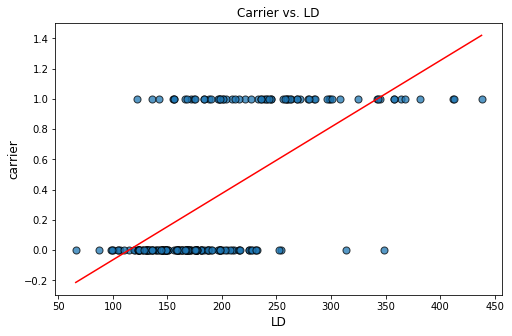

In [15]:
m = lin_reg.coef_[0]
b = lin_reg.intercept_

x = np.linspace(start = X.min(), stop = X.max())
y = m*x + b

alpha = 0.75

fig, ax = plt.subplots(figsize = (8,5))
dystrophy.plot(x = 'LD', y = 'carrier', kind = 'scatter', ax = ax, edgecolor = 'black', s = 50, alpha = alpha)
plt.plot(x, y, color = 'red')

plt.title('Carrier vs. LD')
plt.ylabel('carrier', fontsize = 12)
plt.xlabel('LD', fontsize = 12);

This approach has a big problem: probabilities must be between 0 and 1, but this equation has no guarantee of outputting values between 0 and 1.

In fact, you can see that for some values, there are predictions less than 0 or greater than 1.

Another problem is that it assumes a fixed change in LD will have a fixed effect on the probability. That is, a change from 60 to 70 will have the same impact as a change from 250 to 260.

How can you improve the model?

One approach is to "squash" the output between 0 and 1. A common way to do this is using the **logistic function**:

$$l(x) = \frac{1}{1 + e^{-x}}$$

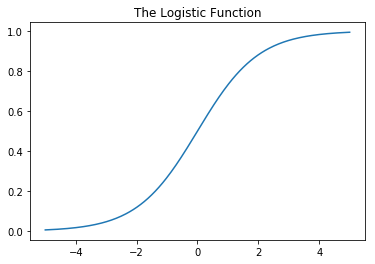

In [16]:
x = np.linspace(-5, 5, num = 250)
y = 1 / (1 + np.exp(-x))

plt.plot(x, y)
plt.title('The Logistic Function');

As you can see, the logistic function maps large positive inputs to values close to 1, large negative inputs to values close to 0, and inputs close to zero get mapped to values close to 0.5.

To use the logistic function, you will take the result of a linear model and feed it into the logistic function, so instead of the model looking like:

$$P(carrier) = \beta_1\cdot(LD) + \beta_0$$

it will look like

$$P(carrier) = \frac{1}{1 + e^{-(\beta_1\cdot(LD) + \beta_0)}}$$

**Important:** The coefficients for this new model will be different from the model above. If you want to fit a logistic regression model, you can use the LogisticRegression module from scikit-learn.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [18]:
lr = LogisticRegression()

In [19]:
le = LabelEncoder()
dystrophy['label'] = le.fit_transform(dystrophy.Class)

In [20]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Like before, once fit, we can inpect the coefficients.

In [21]:
lr.intercept_

array([-6.67946515])

In [22]:
lr.coef_[0]

array([0.03064868])

This means that the model is

$$P(carrier) = \frac{1}{1 + e^{-(0.03065\cdot(LD) - 6.6795)}}$$

Increasing LD results in a higher probability of a person being a carrier.

See what the model looks like now. First, you'll look at the training set.

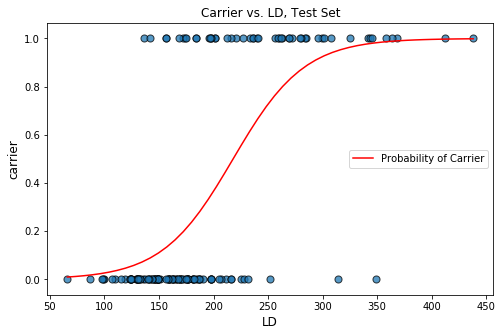

In [23]:
m = lr.coef_[0]
b = lr.intercept_

alpha = 0.75

x_log = np.linspace(start = X.LD.min(), stop = X.LD.max())
y_log = 1 / (1 + np.exp(-(m*x_log + b)))

df = dystrophy.loc[X_train.index]

fig, ax = plt.subplots(figsize = (8,5))
df.plot(x = 'LD', y = 'carrier', kind = 'scatter', ax = ax, alpha = alpha, s = 50, 
        edgecolor = 'black')
plt.plot(x_log, y_log, color = 'red', label = 'Probability of Carrier')

plt.title('Carrier vs. LD, Test Set')
plt.ylabel('carrier', fontsize = 12)
plt.xlabel('LD', fontsize = 12)
plt.legend();


And then the test set.

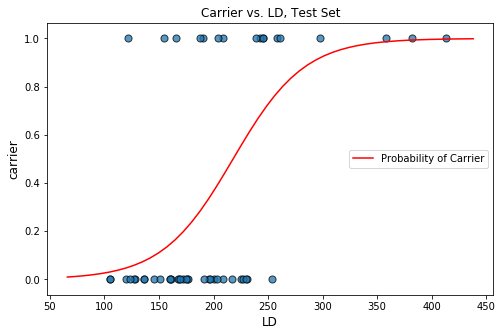

In [24]:
m = lr.coef_[0]
b = lr.intercept_

alpha = 0.75

x_log = np.linspace(start = X.LD.min(), stop = X.LD.max())
y_log = 1 / (1 + np.exp(-(m*x_log + b)))

df = dystrophy.loc[X_test.index]

fig, ax = plt.subplots(figsize = (8,5))
df.plot(x = 'LD', y = 'carrier', kind = 'scatter', ax = ax, alpha = alpha, s = 50, edgecolor = 'black')
plt.plot(x_log, y_log, color = 'red', label = 'Probability of Carrier')

plt.title('Carrier vs. LD, Test Set')
plt.ylabel('carrier', fontsize = 12)
plt.xlabel('LD', fontsize = 12)
plt.legend(loc = 'right');

So how good is this model?

The red sigmoid or s-curve shows the predicted probability associated with a given level of LD.

There are a number of ways to assess such a model. One option is to determine how "calibrated" the model is. That is, if you look at people who you say have a 25% probability of being a carrier, you want about 25% of them to be carriers.

Using this idea, you can build a **calibration curve**. This curve is constructed by:
1. Binning the data into groups based on predicted probabilities.
2. Computing the average predicted probability for each group.
3. Computing the observed proportion for each group, along with a confidence interval (usually a 95% confidence interval).
4. Plot the observed probabilities and confidence intervals against the average probabilities for each group.

Ideally, the plotted points should fall close to the line y = x (because predicted probabilities should be similar to observed probabilities).

In [25]:
from nssstats.plots import calibration_curve

To use this function, you need to pass in the true labels as well as the predicted probabilities. We can access the predicted probabilities using the `predict_proba` function:

In [26]:
y_proba = lr.predict_proba(X_test)
y_proba

array([[0.00650713, 0.99349287],
       [0.78335032, 0.21664968],
       [0.90338434, 0.09661566],
       [0.82207766, 0.17792234],
       [0.82651636, 0.17348364],
       [0.94027573, 0.05972427],
       [0.95264745, 0.04735255],
       [0.56804814, 0.43195186],
       [0.01348287, 0.98651713],
       [0.2265504 , 0.7734496 ],
       [0.87312989, 0.12687011],
       [0.8034334 , 0.1965666 ],
       [0.85516226, 0.14483774],
       [0.63407297, 0.36592703],
       [0.70186964, 0.29813036],
       [0.00252638, 0.99747362],
       [0.4460887 , 0.5539113 ],
       [0.40122133, 0.59877867],
       [0.66202353, 0.33797647],
       [0.94980431, 0.05019569],
       [0.24874846, 0.75125154],
       [0.65513226, 0.34486774],
       [0.56804814, 0.43195186],
       [0.43099711, 0.56900289],
       [0.3037592 , 0.6962408 ],
       [0.31687664, 0.68312336],
       [0.8308671 , 0.1691329 ],
       [0.7781037 , 0.2218963 ],
       [0.34398892, 0.65601108],
       [0.92492641, 0.07507359],
       [0.

This actually outputs two columns. The first column is the predicted probability of _not_ being a carrier and the second give the predicted probability of being a carrier. Notice that the two columns sum to 1, as they should since they represent probabilities.

The calibration curve function expects **just** the probabilities of being a carrier, so we need to slice `y_pred`.

In [27]:
y_proba = y_proba[:,1]
y_proba

array([0.99349287, 0.21664968, 0.09661566, 0.17792234, 0.17348364,
       0.05972427, 0.04735255, 0.43195186, 0.98651713, 0.7734496 ,
       0.12687011, 0.1965666 , 0.14483774, 0.36592703, 0.29813036,
       0.99747362, 0.5539113 , 0.59877867, 0.33797647, 0.05019569,
       0.75125154, 0.34486774, 0.43195186, 0.56900289, 0.6962408 ,
       0.68312336, 0.1691329 , 0.2218963 , 0.65601108, 0.07507359,
       0.14867535, 0.39481058, 0.38751163, 0.03043205, 0.2114934 ,
       0.14483774, 0.78915493, 0.03043205, 0.05802617, 0.18244953,
       0.07507359, 0.59139377, 0.6962408 , 0.28546466, 0.92084181,
       0.30458297, 0.05167721, 0.11389937, 0.49282483])

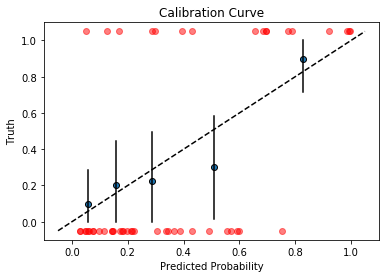

In [28]:
calibration_curve(y_test, y_proba)

The model is decently well calibrated. All of our confidence intervals intersect the line y = x , but the second and third point estimates are a bit low. Also, we have a smallish sample size, so we need to be cautious.

Another way we could look at performance is to calculate how well our model **discriminates** between positive classes and negative classes.

That is, does the model tend to assign higher probabilities to positive observations compared to negative observations.

In [29]:
from nssstats.plots import predicted_probability_plot

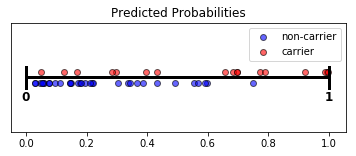

In [30]:
predicted_probability_plot(y_test, y_proba)

In this case, the highest probabilities are assigned to those cases which are carriers. However, there are quite a few carriers who are assigned a low probability.

Closely related to the plot of the predicted probabilities is the Receiver Operator Characteristic Curve (ROC).

This curve shows the tradeoff between correctly classifying those who are carriers vs. incorrectly classifying those who are not carriers as you adjust the threshold for how sure you have to be to predict that a person is a carrier. The axes on the ROC are the **true positive rate**, which measures the proportion of carriers who are correctly predicted as such and the **false positive rate**, which measures the proportion of non-carriers who are incorrectly predicted as being a carrier.

In [31]:
from nssstats.roc import roc_curve

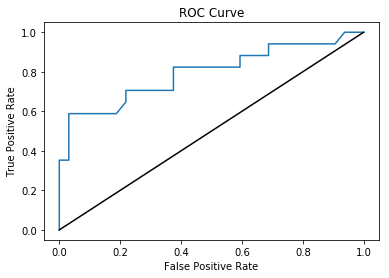

In [32]:
roc_curve(y_test, y_proba);

In [33]:
from ipywidgets import interact, FloatSlider, fixed
from nssstats.roc import tpr_fpr, roc_interact

The widget below shows how the ROC curve is drawn. The threshold represents how high of a predicted probability you need before predicting that someone is a carrier. That is, any points to the right of the threshold will be predicted to be carriers. 

At high threshold values, the model mostly has carriers to the right. By setting a high threshold, you miss out of some of the carriers.

However, if you lower the threshold, you will start to misclassify more and more non-carriers. This demonstrates the tradeoff between the true positive rate and the false positive rate.

In [34]:
tpr, fpr = tpr_fpr(y_test, y_proba)

interact(roc_interact, threshold = FloatSlider(value = 0.5, min = 0, max = 1, step = 0.01, continuous_update = False),
         y_true = fixed(y_test),
         y_prob = fixed(y_proba),
         tpr = fixed(tpr),
         fpr = fixed(fpr),
         alpha = fixed(0.6));

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='threshold', max=1.0, step=0…

A model which discriminates between positive and negative classes really well will be able to increase the True Positive Rate while avoiding increasing the False Positive Rate at the same time.

You can quantify the ability of a model to discriminate by calculating the area under the ROC curve. Areas closer to 1 indicate a model which is better at discriminating between classes.

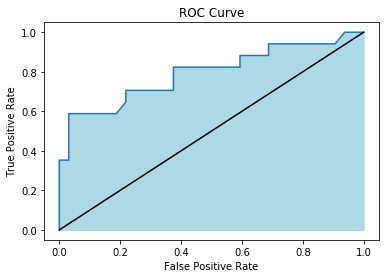

In [35]:
roc_curve(y_test, y_proba, area = True);

You can calculate this area using the roc_auc_score function from scikit-learn.

In [36]:
from sklearn.metrics import roc_auc_score

In [37]:
roc_auc_score(y_test, y_proba)

0.7950367647058824

Finally, take a look at how good the predictions from this model are. You can get predictions using the `lr.predict` method. This returns a predicted class: 0 for non-carrier and 1 for carrier.

In [38]:
y_pred = lr.predict(X_test)
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0])

TODO: describe the plot below

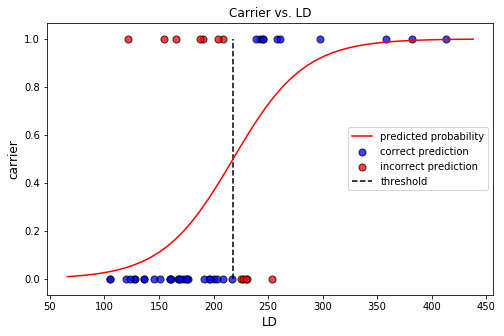

In [39]:
m = lr.coef_[0]
b = lr.intercept_

threshold = -b/m

x_log = np.linspace(start = X.LD.min(), stop = X.LD.max())
y_log = 1 / (1 + np.exp(-(m*x_log + b)))

alpha = 0.75

fig, ax = plt.subplots(figsize = (8,5))

df = dystrophy.loc[X_test.index]

df[y_pred == df.carrier].plot(x = 'LD', y = 'carrier', kind = 'scatter', ax = ax, color = 'blue', 
               edgecolor = 'black', s= 50, label = 'correct prediction', alpha = alpha) 
df[y_pred != df.carrier].plot(x = 'LD', y = 'carrier', kind = 'scatter', ax = ax, color = 'red', 
               edgecolor = 'black', s= 50, label = 'incorrect prediction', alpha = alpha) 
plt.plot(x_log, y_log, color = 'red', label = 'predicted probability')

plt.vlines(x = threshold, ymin = 0, ymax = 1, linestyle = '--', label = 'threshold')

plt.legend(loc = 'right')

plt.title('Carrier vs. LD')
plt.ylabel('carrier', fontsize = 12)
plt.xlabel('LD', fontsize = 12);

A convenient way to analyze these predictions is through the use of a **confusion matrix**.

In [40]:
from nssstats.cm import cm_analysis

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, filename = None, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      figsize:   the size of the figure plotted.

    Modified from https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7#file-plot_confusion_matrix-py
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(object)
    annot_kws = {'fontsize': 12, 'fontweight' : 'bold'}
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j == 0:
                s = cm_sum[i]
                annot[i, j] = 'True Negatives:\n %.1f%%\n%d/%d' % (p, c, s) 
            elif i == j == 1:
                s = cm_sum[i]
                annot[i, j] = 'True Positives:\n %.1f%%\n%d/%d' % (p, c, s)
            elif i == 0 and j == 1:
                s = cm_sum[i]
                annot[i, j] = 'False Positives:\n %.1f%%\n%d/%d' % (p, c, s)
            else:
                s = cm_sum[i]
                annot[i, j] = 'False Negatives:\n %.1f%%\n%d/%d' % (p, c, s)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, linewidths = 2, linecolor = 'black', annot_kws = annot_kws,
               cmap = 'Blues')
    plt.ylabel('Actual', fontsize = 16, fontweight = 'bold')
    plt.xlabel('Predicted', fontsize = 16, fontweight = 'bold')
    ax.set_xticklabels(labels, fontsize = 14, ha = 'center')
    ax.set_yticklabels(labels, fontsize = 14, va = 'center')

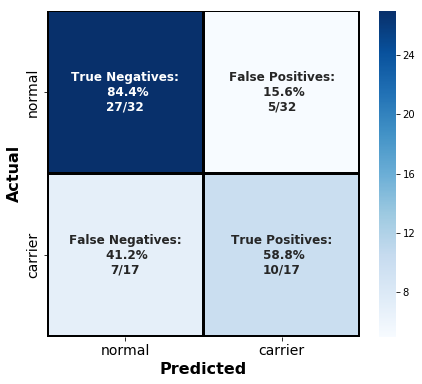

In [95]:
df = dystrophy.loc[X_test.index]
cm_analysis(le.inverse_transform(df.label),
            le.inverse_transform(1 - y_pred), labels = ['normal', 'carrier'],
           figsize = (7,6));

How might you try and improve this model? There are several other measurment variables, so you could try including some of those.

In [ ]:
dystrophy.columns

In [ ]:
X_train = dystrophy.loc[X_train.index, ['CK', 'H', 'PK', 'LD']]
X_test = dystrophy.loc[X_test.index, ['CK', 'H', 'PK', 'LD']]

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

In [ ]:
y_proba = lr.predict_proba(X_test)[:,1]

In [ ]:
calibration_curve(y_test, y_proba, n_bins = 5, strategy = 'quantile')

You can see that it is well calibrated at the top and bottom of the predicted probabilities, but is having some difficulty in the middle range. Now, let's look at how well it discriminates between carriers and non-carriers.

In [ ]:
predicted_probability_plot(y_test, y_proba)

In [ ]:
tpr, fpr = tpr_fpr(y_test, y_proba)

interact(roc_interact, threshold = FloatSlider(value = 0.5, min = 0, max = 1, step = 0.01, continuous_update = False),
         y_true = fixed(y_test),
         y_prob = fixed(y_proba),
         tpr = fixed(tpr),
         fpr = fixed(fpr),
         alpha = fixed(0.6));

In [ ]:
roc_curve(y_test, y_proba, area = True);

In [ ]:
roc_auc_score(y_test, y_proba)

You get a pretty good AUC score.

In [ ]:
y_pred = lr.predict(X_test)

df = dystrophy.loc[X_test.index]

cm_analysis(le.inverse_transform(df.label),
            le.inverse_transform(1 - y_pred), labels = ['normal', 'carrier'],
           figsize = (4,3));

Finally, take a look at the coefficients to understand how each feature influences the prediction.

In [ ]:
coefficients = pd.DataFrame({'feature': X_train.columns, 'coefficient': lr.coef_[0]})
coefficients

All of the coefficients being positive indicates that higher levels of any one of them will tend to indicate a greater chance of being a carrier.